In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import pandas as pd
import os
import sys
from pathlib import Path
import time
from math import radians, cos, sin, asin, sqrt
import numpy as np
import datetime
import overpy
import geopandas as gpd
#from shapely.geometry import Point, Polygon
import requests
import json
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

laptop = 'forgach1mar822'

### Read all important pickles

In [2]:
pickle_dirstring = 'C:/Users/' + laptop + '/Downloads/Egyéb/PICKLE/overpass_data_gpd.p'
overpass_gdf = pd.read_pickle(pickle_dirstring)

pickle_dirstring = 'C:/Users/' + laptop + '/Downloads/Egyéb/PICKLE/station_data_with_height.p'
station_data_df = pd.read_pickle(pickle_dirstring)

pickle_dirstring = 'C:/Users/' + laptop + '/Downloads/Egyéb/PICKLE/bubi_data.p'
bubi_data_df = pd.read_pickle(pickle_dirstring)

overpass_gdf.loc[:, overpass_gdf.columns != 'geometry'].head()
station_data_df.head(2)
bubi_data_df.head(2)

,lat,lon,tags_light_rail,tags_name,tags_railway,tags_train,tags_bus,tags_tram,tags_trolleybus,tags_subway,atm,bank,bar,cafe,cinema,fast_food,pharmacy,post_office,pub,restaurant,theatre
0,47.507152,19.039409,1.0,Batthyány tér,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,47.469158,19.243233,NaN,Rákoshegy,1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,47.525015,19.227709,NaN,Kisherceg vendéglő,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,47.566302,19.047360,NaN,Aquincum,1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,47.598553,19.055045,1.0,Békásmegyer,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,District,Station_id,Station,Rack number,lat,lon,Start date,End date,Move date,Shutdown start,Shutdown end,geometry,height
0,1.0,101.0,0101-Batthyány tér,28.0,47.506406,19.039172,2014-09-08,NaT,2015-01-15,2015-02-01,2015-04-22,POINT (19.03917 47.50641),97.0
1,1.0,102.0,0102-Szilágyi Dezső tér,15.0,47.503424,19.039714,2014-09-08,NaT,NaT,NaT,NaT,POINT (19.03971 47.50342),106.0


,Berles_UID,Start_station,End_station,UID,Bike_number,Ticket,start_time,end_time,time
0,7367458,0709-Rumbach Sebestyén utca - BKK,0709-Rumbach Sebestyén utca - BKK,858994.0,86325.0,féléves bérlet – promóciós,2014-09-08 00:00:32,2014-09-08 00:01:34,0 days 00:01:02
4,7368289,0709-Rumbach Sebestyén utca - BKK,0709-Rumbach Sebestyén utca - BKK,858913.0,86405.0,féléves bérlet – promóciós,2014-09-08 06:55:50,2014-09-08 06:57:22,0 days 00:01:32


### Nearest neighbours of amenities from stations

In [3]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    Inputs in lat, lon format. 
    :params lat1, lon1, lat2, lon2: floats; lat and lon of the two points
    :return: float; distance in metres. 
    """
    try:
        # convert decimal degrees to radians
        lon1, lat1, lon2, lat2 = map(radians, [float(lon1), float(lat1), float(lon2), float(lat2)])

        # haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a))
        r = 6371000 # Radius of earth in meters. Use 3956 for miles
        return int(c * r)
    except Exception as e:
        print(e)
        return None 

    
def haversine_manhattan(lat1,lon1,lat2,lon2):
    """
    """
    lat_dist = haversine(lat1, lon1, lat1, lon2)
    lon_dist = haversine(lat1, lon1, lat2, lon1)
    return (lat_dist+lon_dist)

In [4]:
amenity_list = ['tags_light_rail', 'tags_railway', 'tags_train', 'tags_bus', 'tags_tram', 'tags_trolleybus', 'tags_subway', 'atm', 'bank', 'bar', 'cafe', 'cinema', 'fast_food', 
                'pharmacy', 'post_office', 'pub', 'restaurant', 'theatre']

In [5]:
station_data_df = station_data_df.reset_index(drop=True)

for i in amenity_list:
    X = overpass_gdf[overpass_gdf[i] == 1].loc[:,['lat','lon']]
 
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree',n_jobs=-1, metric = lambda a,b:haversine(a[0],a[1],b[0],b[1])).fit(X)
    distances, indices = nbrs.kneighbors(station_data_df.loc[:,['lat','lon']])
    
    #Make a dataframe with distance from amenities data
    temp_nb_df = pd.DataFrame(overpass_gdf[overpass_gdf[i] == 1].reset_index(drop=True).iloc[indices.flatten()][['lat', 'lon']])
    temp_nb_df = temp_nb_df.reset_index(drop=True)
    
    station_data_df[str(i)+'_dist'] = distances

### Nearest neighbours - Bubi állomások egymáshoz képest

In [6]:
temp_nb_station_data_df = station_data_df.loc[:,['Station', 'lat','lon', 'geometry']]

In [7]:
temp_nb_station_data_df = temp_nb_station_data_df.reset_index(drop=True)
X=temp_nb_station_data_df.loc[:,['lat','lon']]

station_data_df = station_data_df.reset_index(drop=True)

nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree',n_jobs=-1, metric = lambda a,b:haversine(a[0],a[1],b[0],b[1])).fit(X)
distances, indices = nbrs.kneighbors(station_data_df.loc[:,['lat','lon']])

#distances convert, because NN algorithm finds the nearest station which is itself
distances = distances[:,[1]]
indices = indices[:,[1]]

Wall time: 198 ms


In [8]:
temp_nb2_df = pd.DataFrame(temp_nb_station_data_df.iloc[indices.flatten()][['lat', 'lon']])
temp_nb2_df = temp_nb2_df.reset_index(drop=True)

station_data_df['nearest_bubi_dist'] = distances

In [9]:
station_data_df.head(2)

,District,Station_id,Station,Rack number,lat,lon,Start date,End date,Move date,Shutdown start,Shutdown end,geometry,height,tags_light_rail_dist,tags_railway_dist,tags_train_dist,tags_bus_dist,tags_tram_dist,tags_trolleybus_dist,tags_subway_dist,atm_dist,bank_dist,bar_dist,cafe_dist,cinema_dist,fast_food_dist,pharmacy_dist,post_office_dist,pub_dist,restaurant_dist,theatre_dist,nearest_bubi_dist
0,1.0,101.0,0101-Batthyány tér,28.0,47.506406,19.039172,2014-09-08,NaT,2015-01-15,2015-02-01,2015-04-22,POINT (19.03917 47.50641),97.0,40.0,52.0,1293.0,33.0,52.0,2026.0,58.0,16.0,107.0,454.0,100.0,574.0,89.0,121.0,110.0,166.0,85.0,776.0,334.0
1,1.0,102.0,0102-Szilágyi Dezső tér,15.0,47.503424,19.039714,2014-09-08,NaT,NaT,NaT,NaT,POINT (19.03971 47.50342),106.0,318.0,129.0,1157.0,300.0,129.0,1795.0,362.0,245.0,300.0,134.0,137.0,389.0,311.0,327.0,420.0,147.0,34.0,619.0,334.0


## Count of amenities, stations within 300 m

In [10]:
## BUBI STATIONS

from scipy.spatial import cKDTree
from scipy import inf

max_distance = 0.0027 # Assuming lats and longs are in decimal degrees, 0.0001 corresponds to 11.1 meters, 0.0027 = ~300 m
points = station_data_df.loc[:,['lat','lon']].values.tolist()
tree = cKDTree(points)

point_neighbors_list = [] # Put the neighbors of each point here

for point in points:
    distances, indices = tree.query(point, len(points), p=2, distance_upper_bound=max_distance)
    #point_neighbors = []
    point_count = -1
    for index, distance in zip(indices, distances):
        if distance == inf:
            break
        #point_neighbors.append(points[index])
        point_count +=1
    #point_neighbors_list.append(point_neighbors)
    point_neighbors_list.append(point_count)
    
station_data_df['bubi_stations_near'] = point_neighbors_list

In [11]:
station_data_df.bubi_stations_near.describe()

count    159.000000
mean       0.578616
std        0.844818
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        4.000000
Name: bubi_stations_near, dtype: float64

In [12]:
## AMENITIES

amenity_list = ['tags_light_rail', 'tags_railway', 'tags_train', 'tags_bus', 'tags_tram', 'tags_trolleybus', 'tags_subway', 'atm', 'bank', 'bar', 'cafe', 'cinema', 'fast_food', 
                'pharmacy', 'post_office', 'pub', 'restaurant', 'theatre']

from sklearn.neighbors import KDTree

for i in amenity_list:
    points = overpass_gdf[overpass_gdf[i] == 1].loc[:,['lat','lon']].values.tolist()
    #points = overpass_gdf.loc[:,['lat','lon']].values.tolist()
    tree = KDTree(points)
    nearest_count = tree.query_radius(station_data_df.loc[:,['lat','lon']],r=0.0027,count_only=True)
    station_data_df[str(i)+'_nearby'] = nearest_count

In [14]:
station_data_df.head(2)

,District,Station_id,Station,Rack number,lat,lon,Start date,End date,Move date,Shutdown start,Shutdown end,geometry,height,tags_light_rail_dist,tags_railway_dist,tags_train_dist,tags_bus_dist,tags_tram_dist,tags_trolleybus_dist,tags_subway_dist,atm_dist,bank_dist,bar_dist,cafe_dist,cinema_dist,fast_food_dist,pharmacy_dist,post_office_dist,pub_dist,restaurant_dist,theatre_dist,nearest_bubi_dist,bubi_stations_near,tags_light_rail_nearby,tags_railway_nearby,tags_train_nearby,tags_bus_nearby,tags_tram_nearby,tags_trolleybus_nearby,tags_subway_nearby,atm_nearby,bank_nearby,bar_nearby,cafe_nearby,cinema_nearby,fast_food_nearby,pharmacy_nearby,post_office_nearby,pub_nearby,restaurant_nearby,theatre_nearby
0,1.0,101.0,0101-Batthyány tér,28.0,47.506406,19.039172,2014-09-08,NaT,2015-01-15,2015-02-01,2015-04-22,POINT (19.03917 47.50641),97.0,40.0,52.0,1293.0,33.0,52.0,2026.0,58.0,16.0,107.0,454.0,100.0,574.0,89.0,121.0,110.0,166.0,85.0,776.0,334.0,0,4,5,0,4,2,0,2,5,2,0,3,0,2,2,1,4,6,0
1,1.0,102.0,0102-Szilágyi Dezső tér,15.0,47.503424,19.039714,2014-09-08,NaT,NaT,NaT,NaT,POINT (19.03971 47.50342),106.0,318.0,129.0,1157.0,300.0,129.0,1795.0,362.0,245.0,300.0,134.0,137.0,389.0,311.0,327.0,420.0,147.0,34.0,619.0,334.0,0,0,4,0,0,4,0,0,2,0,1,3,0,0,0,0,2,9,0


## Correlation heatmap

In [21]:
station_data_df_features = station_data_df[[
                'Rack number', 'height', 'tags_light_rail_dist', 'tags_railway_dist', 'tags_train_dist',
                'tags_bus_dist', 'tags_tram_dist', 'tags_trolleybus_dist', 'tags_subway_dist', 'atm_dist', 'bank_dist', 'bar_dist', 'cafe_dist',
                'cinema_dist', 'fast_food_dist', 'pharmacy_dist', 'post_office_dist', 'pub_dist', 'restaurant_dist', 'theatre_dist', 'nearest_bubi_dist', 'bubi_stations_near',
                'tags_light_rail_nearby', 'tags_railway_nearby', 'tags_train_nearby', 'tags_bus_nearby', 'tags_tram_nearby', 
                'tags_trolleybus_nearby', 'tags_subway_nearby', 'atm_nearby', 'bank_nearby', 'bar_nearby', 'cafe_nearby', 'cinema_nearby',
                'fast_food_nearby', 'pharmacy_nearby', 'post_office_nearby','pub_nearby', 'restaurant_nearby', 'theatre_nearby' ]].head(2)

<Figure size 1800x1800 with 0 Axes>

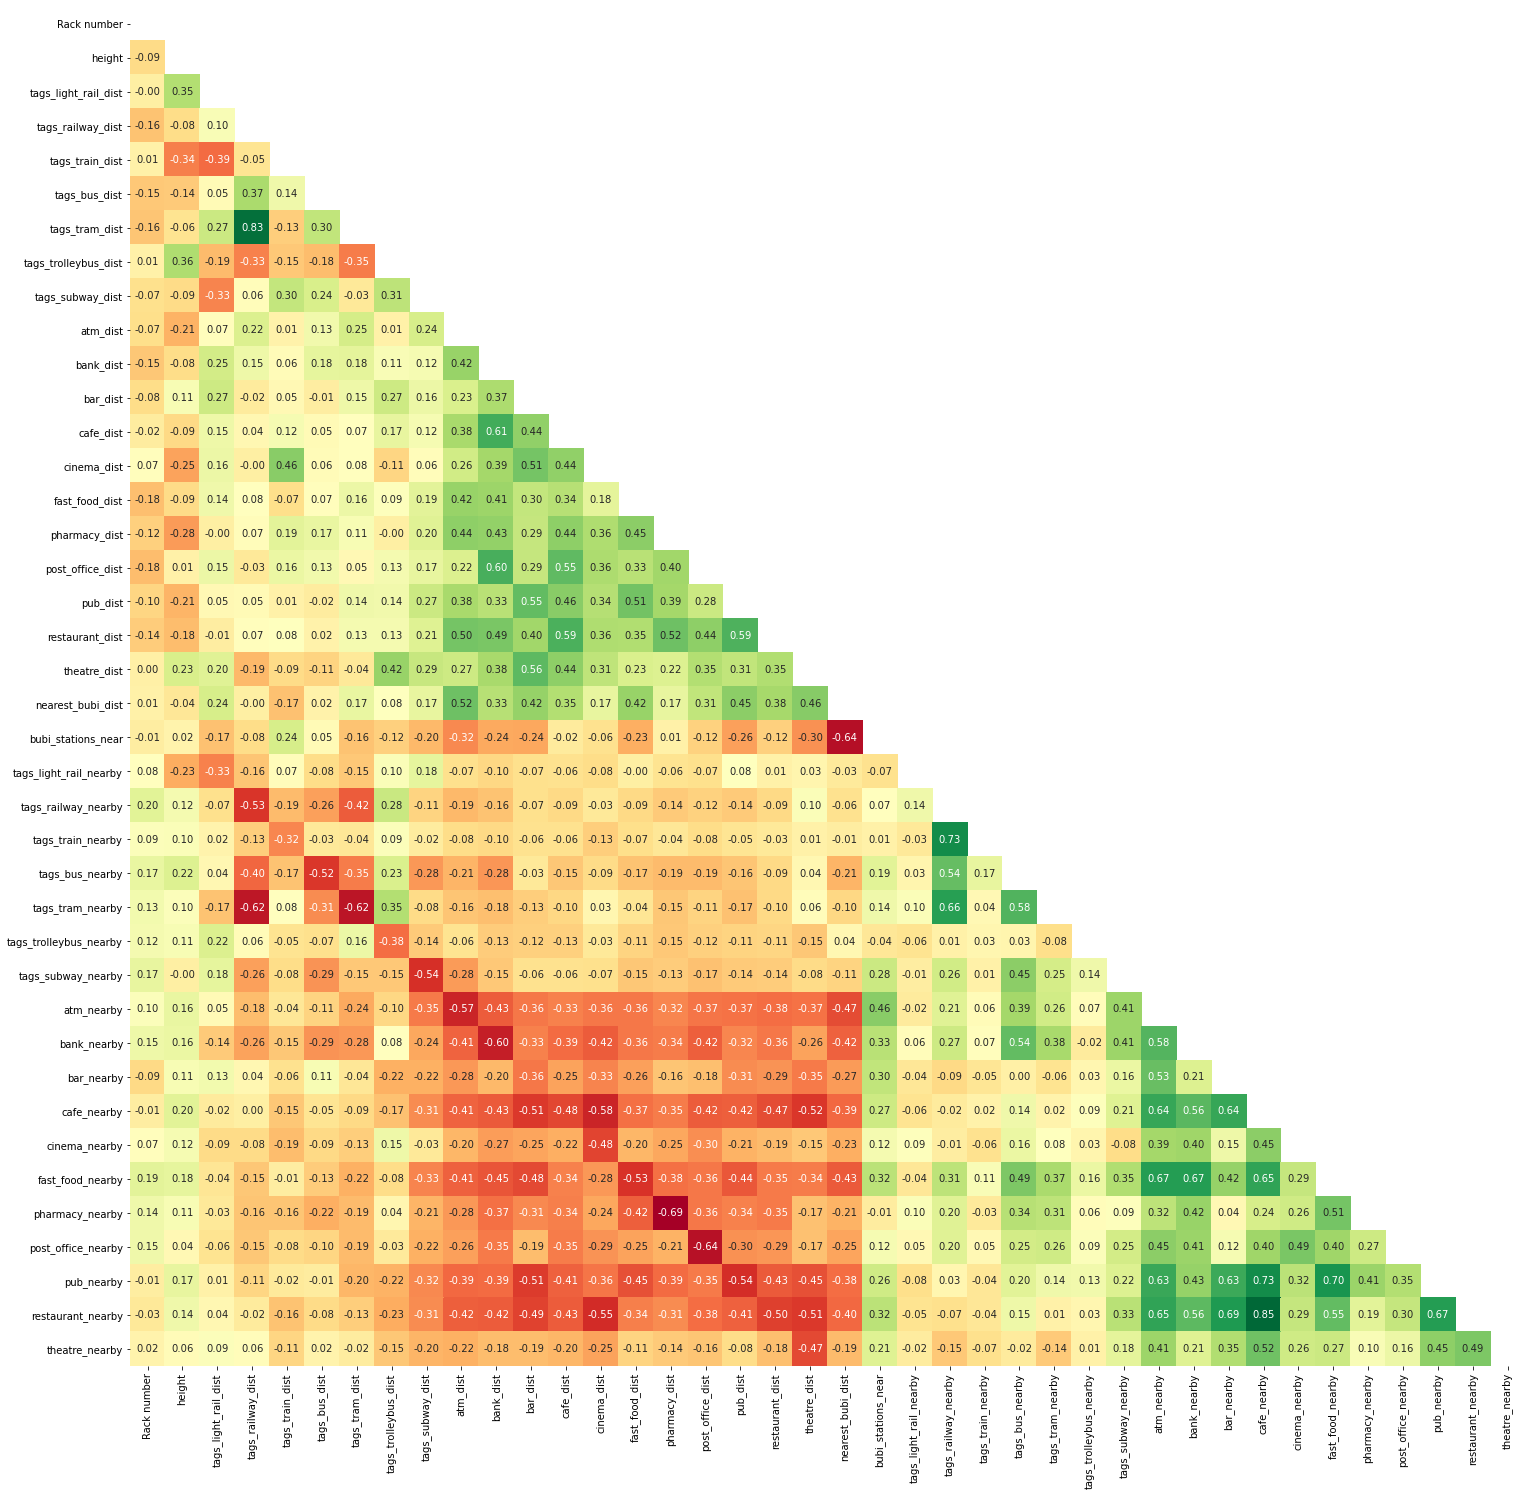

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns

X = station_data_df_features

##target column i.e price range
#y = station_data_fi_df[['Start_count']]

corrmat = station_data_df_features.corr()
top_corr_features = corrmat.index

#plot heat map
mask = np.zeros_like(corrmat, dtype=bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25, 25))
g=sns.heatmap(station_data_df[top_corr_features].corr(),annot=True, cmap="RdYlGn", cbar = False, fmt='.2f', mask=mask)
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

In [47]:
# ## Drop

# ## Highest correlators
# restaurant_nearby       cafe_nearby               0.850365
# tags_tram_dist          tags_railway_dist         0.825073
# tags_train_nearby       tags_railway_nearby       0.734643
# pub_nearby              cafe_nearby               0.731058
# fast_food_nearby        pub_nearby                0.700479
# pharmacy_dist           pharmacy_nearby           0.695005
# restaurant_nearby       bar_nearby                0.687026
# atm_nearby              fast_food_nearby          0.673783
# bank_nearby             fast_food_nearby          0.672453
# restaurant_nearby       pub_nearby                0.671731
# tags_railway_nearby     tags_tram_nearby          0.664215
# restaurant_nearby       atm_nearby                0.650855
# fast_food_nearby        cafe_nearby               0.646564
# bar_nearby              cafe_nearby               0.640246
# atm_nearby              cafe_nearby               0.638380
# bubi_stations_near      nearest_bubi_dist         0.637863
# post_office_nearby      post_office_dist          0.634932
# pub_nearby              bar_nearby                0.628446
# pub_nearby              atm_nearby                0.626820
# District                cinema_dist               0.626290
# tags_tram_dist          tags_tram_nearby          0.625449
# post_office_dist        bank_dist                 0.623616
# tags_tram_nearby        tags_railway_dist         0.615542
# bank_dist               cafe_dist                 0.611779